# What's in our Geostore, anyway?

We spend a fair amount of time and money optimizing our analysis services for our users. One way we do this is by preprocessing a bunch of statistics at the country level. It takes a little while to generate these statistics, but in general is a pretty easy way to improve the user experience.

Responding to on-the-fly user requests is much tougher. In the past two years, we've used any combination of CARTO, ArcGIS ImageServer, Google Earth Engine and Elasticsearch to handle this need.

All of the above methods have strengths and weaknesses, but perhaps we should first examine the geostore itself. What polygons are people interested in? Are they large or small? Complex or general? And where are they anyway?

In [3]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Let's check out our data as centroid points first
df = gpd.read_file('final_all_valid_point.geojson')

df.head()

,ORIG_FID,_id,area_ha,geometry,vertex_cou
0,0,{u'$oid': u'57e9a66440af830c00cc0984'},0.642146,POINT (-74.88049499999988 -8.219198),5
1,1,{u'$oid': u'57eb590840af830c00cc0c03'},0.642146,POINT (-74.88980799999985 -8.215120000000001),5
2,2,{u'$oid': u'57e9a84540af830c00cc0988'},0.642146,POINT (-74.884229 -8.221874),5
3,3,{u'$oid': u'57e9d0a7deb84616005f6505'},0.642146,POINT (-74.872534 -8.19623),5
4,4,{u'$oid': u'57e9d0be40af830c00cc098e'},18.183547,POINT (-74.87276645306349 -8.196083114109001),5


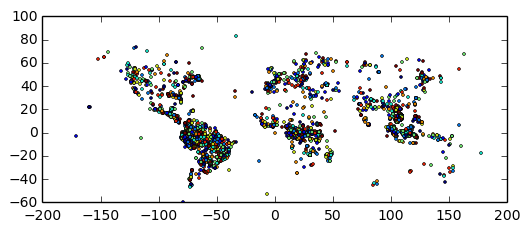

In [5]:
# Grab a sample of the dataframe to plot
sample = df.sample(5000)

sample.plot()

In [6]:
# Now let's run some stats to try and find the "average" geostore

df.area_ha.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

count    5.541400e+04
mean     6.204411e+07
std      7.020194e+08
min      9.641852e-05
25%      1.660290e+04
50%      3.983751e+05
75%      8.621682e+05
90%      2.275573e+07
99%      1.013890e+09
max      3.192607e+10
Name: area_ha, dtype: float64

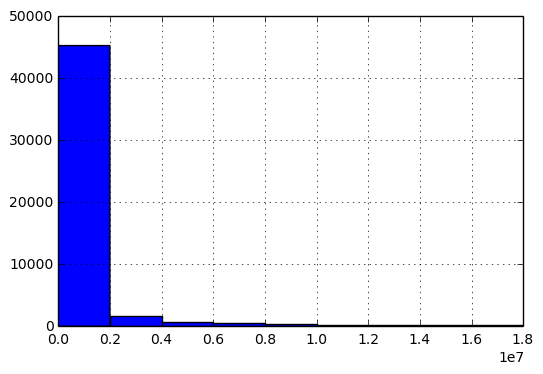

In [7]:
# Create bins with a max of 20,000,000 ha, or just larger than the area of Russia
bin_values = np.arange(start=0, stop=20000000, step=2000000)

df.area_ha.hist(bins=bin_values)

Ok, so there are some pretty large geostores out there.
What about comparing them to the size of the [test polygon in paraguay](https://github.com/wri/compare-imageserver-gee/blob/master/geojson/paraguay.geojson)?

This was the breakpoint when comparing ArcGIS Server and GEE-- GEE was able to return fairly consistent results for this area, while ImageServer returned an error [almost 50% of the time](https://github.com/wri/compare-imageserver-gee/blob/master/results/hist-results-plots/paraguay_error_count.png).

The area of this polygon in World Eckert VI is 3356774 hectares, or about the size of Maryland. Let's split up the geostore by polygon size to see how frequently a request of this size comes up.

In [20]:
df['over_esri_threshold'] = df.area_ha > 3356774

#df.sample(1000).over_esri_threshold.plot(kind='bar')#, bins=[0,0.5,1])

df.over_esri_threshold.value_counts()

False    46524
True      8890
Name: over_esri_threshold, dtype: int64